In [1]:
import os

os.chdir("../")

from dotenv import load_dotenv

%load_ext autoreload
%autoreload 2

load_dotenv(".env")

True

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch

import constants

# Data preparation imports
from src.features.feature_service import FeatureService
from src.features.feature_generators.technical_indicators import (
    EMA, SMA, BB, OBV, MACD, RSI
)
from src.features.feature_generators.datetime import DateTime
from src.labelers import BinaryLabeler

# Model imports
from src.model.datasets import SlidingWindowDataset
from src.model.architectures import TransformerBinaryClassifier
from src.model.wrappers import BinaryModelWrapper

# Backtester imports
from src.evaluation.metrics import evaluate_binary
from src.evaluation import Backtester

In [3]:
# Plot styling
TEXT_COLOR = "#313131"

# Plotly colors
LINE_COLORS = [
    "#636EFA",
    "#EF553B",
    "#00CC96",
    "#AB63FA",
    "#FFA15A",
    "#19D3F3",
    "#FF6692",
    "#B6E880",
    "#FF97FF",
    "#FECB52",
]

sns.set(
    style="darkgrid",
    rc={
        "figure.figsize": (6, 4),
        "figure.dpi": 100,
        "figure.facecolor": "w",
        "legend.facecolor": "w",
        "text.color": TEXT_COLOR,
        "font.family": "Microsoft Sans Serif",
        "axes.labelcolor": TEXT_COLOR,
        "xtick.color": TEXT_COLOR,
        "ytick.color": TEXT_COLOR,
    },
)

sns.set_palette(sns.color_palette(LINE_COLORS))

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TARGET_COL = "BTCUSDT_close"

# Create dataset

In [5]:
df = pd.read_parquet("data/binance")

In [6]:
# Get only 10k rows to test the functionality
df = df.iloc[:10000]

### Generate features

In [7]:
symbols = [
    f"{asset}{constants.FIAT_TO_TRADE}" 
    for asset in [constants.ASSET_TO_TRADE, *constants.PREDICTOR_ASSETS] 
]

generators = []

# Moving averages
generators += [
    indicator(input_col=f"{symbol}_close", period=period)
    for indicator in [EMA, SMA]
    for symbol in symbols
    for period in [9, 21, 50]
]

# MACD
generators += [
    MACD(
        input_col=f"{symbol}_close", 
        fast_period=12, 
        slow_period=26, 
        signal_period=9,
    )
    for symbol in symbols
]

# RSI
generators += [
    RSI(input_col=f"{symbol}_close")
    for symbol in symbols
]

# Bollinger bands
generators += [
    BB(input_col=f"{symbol}_close")
    for symbol in symbols
]

# OBV
generators += [
    OBV(
        open_col=f"{symbol}_open",
        close_col=f"{symbol}_close",
        high_col=f"{symbol}_high",
        low_col=f"{symbol}_low",
        volume_col=f"{symbol}_volume",
    )
    for symbol in symbols
]

# DateTime
generators += [
    DateTime(timestamp_col="open_timestamp")
]

In [8]:
service = FeatureService(*generators)

In [9]:
%%time
service.initialize(df)

CPU times: user 1.99 s, sys: 29.1 ms, total: 2.02 s
Wall time: 2.03 s


In [10]:
%%time
# Features DF
features_df = pd.DataFrame(service.output_values)

CPU times: user 166 ms, sys: 11.4 ms, total: 178 ms
Wall time: 180 ms


### Generate labels

In [11]:
labeler = BinaryLabeler(price_col=TARGET_COL, period=5)

In [12]:
features_df["target"] = labeler.transform(df)

### Prepare data for training

In [13]:
data = pd.concat(
    (df, features_df),
    axis=1,
).dropna()

In [14]:
x = data.drop(["time", "open_timestamp", "date"], axis=1).astype(float)
y = data["target"].astype(float)

In [15]:
x = torch.Tensor(x.values).to(torch.float).to(DEVICE)
y = torch.Tensor(y.values).to(torch.float).to(DEVICE)

In [16]:
x.size(), y.size()

(torch.Size([9946, 151]), torch.Size([9946]))

---

# Run Backtest

In [17]:
model = TransformerBinaryClassifier(
    n_features=x.size(1),
    n_embedding_dims=64,
    n_head=8,
    n_layers=2,
)

In [18]:
wrapper = BinaryModelWrapper(
    model=model,
    batch_size=128,
    loss_fn=torch.nn.BCELoss(),
    dataset_builder=SlidingWindowDataset,
    lr_decay_multiplier=0.9,
    lr_decay_step=2,
)

In [19]:
backtester = Backtester(
    wrapper=wrapper,
    evaluation_fn=evaluate_binary,
    x=x,
    y=y,
    gap_proportion=0.2,
    valid_proportion=0.3,
    n_splits=2,
)

Split 1
Train start: 0 | Train end: 3825 | Valid start: 5355 | Valid end: 7650


/Users/pavlo.seimskyi/Desktop/github-repos/crypto-bot/.venv/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:132: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Seems like `optimizer.step()` has been overridden after learning rate scheduler "


Epoch: 1 | Train Loss: 0.798 | Valid Loss: 0.729
Epoch: 2 | Train Loss: 0.802 | Valid Loss: 0.799
Epoch: 3 | Train Loss: 0.804 | Valid Loss: 0.754
Epoch: 4 | Train Loss: 0.796 | Valid Loss: 0.747
Epoch: 5 | Train Loss: 0.807 | Valid Loss: 0.757
Epoch: 6 | Train Loss: 0.795 | Valid Loss: 0.790
Epoch: 7 | Train Loss: 0.790 | Valid Loss: 0.784
Epoch: 8 | Train Loss: 0.797 | Valid Loss: 0.786
Epoch: 9 | Train Loss: 0.790 | Valid Loss: 0.781
Epoch: 10 | Train Loss: 0.795 | Valid Loss: 0.776
accuracy: 0.505, f1: 0.436, precision: 0.499, recall: 0.386, avg_precision_score: 0.515


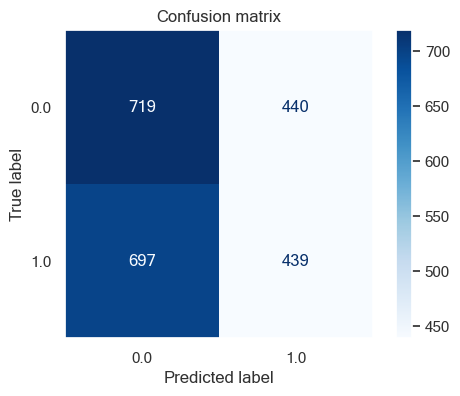

Split 2
Train start: 2295 | Train end: 6120 | Valid start: 7650 | Valid end: 9945
Epoch: 1 | Train Loss: 0.805 | Valid Loss: 1.153
Epoch: 2 | Train Loss: 0.808 | Valid Loss: 1.158
Epoch: 3 | Train Loss: 0.806 | Valid Loss: 1.104
Epoch: 4 | Train Loss: 0.795 | Valid Loss: 1.139
Epoch: 5 | Train Loss: 0.793 | Valid Loss: 1.020
Epoch: 6 | Train Loss: 0.801 | Valid Loss: 1.004
Epoch: 7 | Train Loss: 0.792 | Valid Loss: 1.022
Epoch: 8 | Train Loss: 0.775 | Valid Loss: 0.983
Epoch: 9 | Train Loss: 0.810 | Valid Loss: 0.984
Epoch: 10 | Train Loss: 0.795 | Valid Loss: 0.928
accuracy: 0.485, f1: 0.654, precision: 0.485, recall: 1.0, avg_precision_score: 0.515


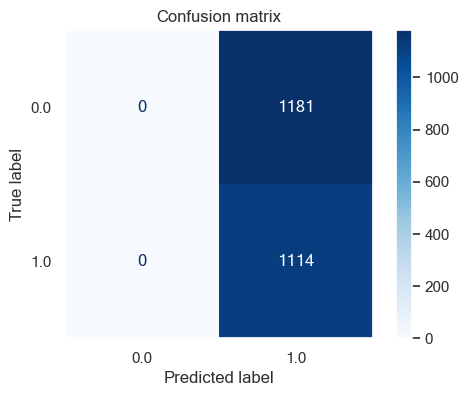

FINAL RESULTS
accuracy: 0.495, f1: 0.573, precision: 0.489, recall: 0.69, avg_precision_score: 0.503


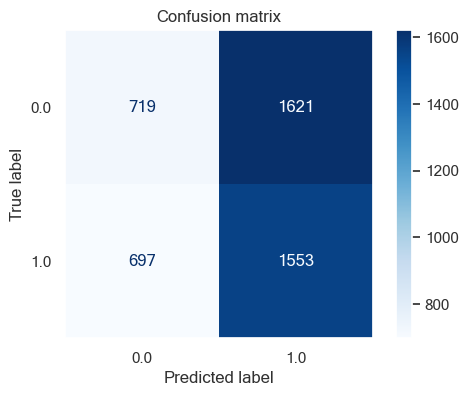

In [20]:
backtester.run()

---